# Units Test Notebook

In [1]:
import pandas as pd
import numpy as np
import os
import json
from IPython.display import display, HTML
import sys

current_dir = os.path.dirname(os.path.abspath(''))
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

# Import project modules
import config 
from data_loader import load_all_dataframes
from preprocess import translate_dataframes, process_tech_cat_names
from feature_engineering import create_ceramic_summary, generate_one_hot_embeddings
from graph_utils import (
    build_category_hierarchy_and_map_ceramics,
    calculate_completeness_score,
    extract_triplets_for_selection,
    get_parents,
    memo_parents
)
from src.data_preparation.format_rgcn_data import (
    format_rgcn_data_with_hybrid_embeddings
)
# Corrected import path for adapt_rgcn_data_for_ceramic_classification
from data_preparation.format_rgcn_mlp_classification_data import (
    adapt_rgcn_data_for_ceramic_classification
)
from data_preparation.format_mlp_classification_data import (
    create_mlp_input_data
)
from utils import seed_everything, get_feature_parent_relation_label

# --- Configuration for the Test ---
seed_everything(42)

# LOCAL_DATA_PATH_TEST will come from the imported config module
LOCAL_DATA_PATH_TEST = config.LOCAL_DATA_PATH
OUTPUT_TEST_DIR = os.path.join(config.OUTPUT_BASE_DIR, "test_outputs")
os.makedirs(OUTPUT_TEST_DIR, exist_ok=True)

TEST_CERAMIC_IDS_ORIGINAL = [48, 49, 10601]

print("Setup complete. Modules imported.")
print(f"Using data from: {LOCAL_DATA_PATH_TEST}") # This now uses config.LOCAL_DATA_PATH
print(f"Test outputs will be in: {OUTPUT_TEST_DIR}")
print(f"Testing with original ceramic IDs: {TEST_CERAMIC_IDS_ORIGINAL}")

Seeded everything with seed 42
Setup complete. Modules imported.
Using data from: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\data
Test outputs will be in: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\test_outputs
Testing with original ceramic IDs: [48, 49, 10601]


## 1. Select 3 Ceramics as Examples to treat

In [2]:
# Load the prepared ceramic summary data
ceramic_summary_df = pd.read_csv('C:/Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\ceramic_summary_prepared.csv')

# Set pandas display options to show full content
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

# Display raw data for test ceramics
print("--- Raw Data for Test Ceramics from ceramic_summary_prepared.csv ---")

# Filter data for all test ceramic IDs
test_ceramics_data = ceramic_summary_df[ceramic_summary_df['ceramic_id'].isin(TEST_CERAMIC_IDS_ORIGINAL)]

if not test_ceramics_data.empty:
    print(f"\nFound {len(test_ceramics_data)} ceramic records")
    
    # Display in HTML format for better readability
    from IPython.display import HTML
    
    # Create HTML table with better formatting
    html_table = test_ceramics_data.to_html(
        escape=False,
        index=False,
        table_id='ceramics_table',
        classes='table table-striped table-bordered'
    )
    
    # Add some CSS styling for better readability
    styled_html = f"""
    <style>
    #ceramics_table {{
        font-size: 12px;
        border-collapse: collapse;
        width: 100%;
    }}
    #ceramics_table th, #ceramics_table td {{
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
        vertical-align: top;
        word-wrap: break-word;
        max-width: 300px;
    }}
    #ceramics_table th {{
        background-color: #f2f2f2;
        font-weight: bold;
    }}
    #ceramics_table tr:nth-child(even) {{
        background-color: #f9f9f9;
    }}
    </style>
    {html_table}
    """
    
    display(HTML(styled_html))
    
    # Also display each ceramic individually for detailed view
    print("\n--- Individual Ceramic Details ---")
    for ceramic_id in TEST_CERAMIC_IDS_ORIGINAL:
        ceramic_row = ceramic_summary_df[ceramic_summary_df['ceramic_id'] == ceramic_id]
        if not ceramic_row.empty:
            print(f"\n{'='*50}")
            print(f"CERAMIC ID: {ceramic_id}")
            print(f"{'='*50}")
            
            # Display each column and its value
            for column in ceramic_row.columns:
                value = ceramic_row[column].iloc[0]
                if pd.notna(value) and str(value).strip():
                    print(f"{column}: {value}")
                    print("-" * 30)
        else:
            print(f"No data found for Ceramic ID {ceramic_id}")
            
else:
    print("No ceramic data found for the specified IDs")

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\moham\AppData\Local\Temp\ipykernel_15128\1639807925.py:2: SyntaxWarning: invalid escape sequence '\m'
  ceramic_summary_df = pd.read_csv('C:/Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\ceramic_summary_prepared.csv')


--- Raw Data for Test Ceramics from ceramic_summary_prepared.csv ---

Found 3 ceramic records


ceramic_id,ceramic_identifier,origin,tech_cat_id,tech_cat_name,reuse,production_fail,period_name_fr,context_type_name,identifier_origin_source_name,function_id,function_name_fr,feature_id,feature_name_fr,color_name_list,description
48,19188,"Sainte-Barbe, France",-1,Unknown Category,NaN,True,NaN,production,LA3M/LAMM Inventory,[np.int64(11)],['pitcher (or jug)'],"[np.int64(3), np.int64(16), np.int64(41), np.int64(49)]","['Calcareous', 'Lead glaze', 'Oxidizing', 'Thrown']",['Green'],A Green ceramic with a production fault from the production in Sainte-Barbe.
49,26274,"Collège Eugène Vigne, France",1,Category Kaolinitic from the Uzège group,NaN,False,NaN,production,LA3M/LAMM Inventory,[np.int64(11)],['pitcher (or jug)'],"[np.int64(3), np.int64(19), np.int64(41), np.int64(49)]","['Kaolinitic', 'Lead glaze', 'Oxidizing', 'Thrown']",[],A Ceramic ceramic from the production in Collège Eugène Vigne.
10601,3-8,"Hôtel d'Agar, France",94,"Category White kaolinitic, glazed",False,False,époque moderne occidentale,consumption,Site Archives,[np.int64(21)],['cooking pot'],"[np.int64(3), np.int64(19), np.int64(41), np.int64(49)]","['Kaolinitic', 'Lead glaze', 'Oxidizing', 'Thrown']",[],A Ceramic ceramic from the consumption in Hôtel d'Agar.



--- Individual Ceramic Details ---

CERAMIC ID: 48
ceramic_id: 48
------------------------------
ceramic_identifier: 19188
------------------------------
origin: Sainte-Barbe, France
------------------------------
tech_cat_id: -1
------------------------------
tech_cat_name: Unknown Category
------------------------------
production_fail: True
------------------------------
context_type_name: production
------------------------------
identifier_origin_source_name: LA3M/LAMM Inventory
------------------------------
function_id: [np.int64(11)]
------------------------------
function_name_fr: ['pitcher (or jug)']
------------------------------
feature_id: [np.int64(3), np.int64(16), np.int64(41), np.int64(49)]
------------------------------
feature_name_fr: ['Calcareous', 'Lead glaze', 'Oxidizing', 'Thrown']
------------------------------
color_name_list: ['Green']
------------------------------
description: A Green ceramic with a production fault from the production in Sainte-Barbe.
---

## 2. Generate One-Hot Embeddings (For mlp)

In [3]:
dfs_raw = load_all_dataframes(data_base_path=LOCAL_DATA_PATH_TEST)
dfs_raw['ceramic_summary'] = ceramic_summary_df

print("\n--- Testing create_mlp_input_data ---")

dfs_for_mlp_test = dfs_raw.copy()

print("\n--- Testing create_mlp_input_data ---")
if 'ceramic_summary' not in dfs_for_mlp_test or dfs_for_mlp_test['ceramic_summary'].empty:
    if 'ceramic_summary_df' in locals() and not ceramic_summary_df.empty:
        dfs_for_mlp_test['ceramic_summary'] = ceramic_summary_df
    else:
        print("ERROR: ceramic_summary_df not available for MLP data creation test.")

# --- Test with Embedding Type 1 (Functions + Features) for 'etude1' sampling ---
print("\n--- Testing MLP Data Creation: Study 'etude1', Embedding Type 1 (Functions + Features) ---")
X_mlp_e1_t1, y_mlp_e1_t1, root_names_e1_t1, maps_e1_t1, emb_info_e1_t1 = create_mlp_input_data(
    dfs_for_mlp_test,
    study_name="etude1",
    embedding_type=0
)

if X_mlp_e1_t1 is not None:
    print(f"\nData for etude1, type 1:")
    print(f"  X_mlp shape: {X_mlp_e1_t1.shape}")
    print(f"  y_mlp shape: {y_mlp_e1_t1.shape}")
    print(f"  Number of unique labels: {len(np.unique(y_mlp_e1_t1))}")
    print(f"  Embedding info: {emb_info_e1_t1}")

    print("\n--- Verifying embedding for a specific test ceramic (if present in the sample) ---")
    if X_mlp_e1_t1.shape[0] > 0:
        print(f"  Example MLP Embedding (first ceramic in etude1, type 1 sample):")
        print(f"    Length: {len(X_mlp_e1_t1[2])}")
        
        print(f"    Embedding (first 20 values): {X_mlp_e1_t1[2]}")
      #  print(f"    Embedding (Functions): {X_mlp_e1_t1[2][:181]}")
      #  print(f"    Embedding (Features): {X_mlp_e1_t1[2][181:]}")
        print(f"    Corresponding label: {y_mlp_e1_t1[2]} ({root_names_e1_t1.get(y_mlp_e1_t1[2])})")
else:
    print("MLP data creation for etude1, type 1 failed.")

Loading data from: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\data
  Loaded ceramic.csv as dfs['ceramic']
  Loaded object_colors.csv as dfs['object_colors']
  Loaded object_colors_attrib.csv as dfs['object_colors_attrib']
  Loaded object_feature.csv as dfs['object_feature']
  Loaded object_feature_combined_names.csv as dfs['object_feature_combined_names']
  Loaded object_feature_attrib.csv as dfs['object_feature_attrib']
  Loaded object_function_translated.csv as dfs['object_function']
  Loaded object_function_attrib.csv as dfs['object_function_attrib']
  Loaded tech_cat_translated.csv as dfs['tech_cat']
  Loaded archaeological_sites.csv as dfs['archaeological_sites']
  Loaded traditional_designation.csv as dfs['traditional_designation']
  Loaded historical_period.csv as dfs['historical_period']
  Loaded tech_cat_color_attrib.csv as dfs['tech_cat_color_attrib']
  Loaded tech_cat_feature_attrib.csv as dfs['tech_cat_feature_attrib']
  Loaded tech_cat_function_attrib.csv as dfs['te

## 3. RGCN DATA (Bert Embedding)

### 3.A Triplets Extraction

In [4]:
import ast
import re
import numpy as np

# Function to safely parse list-like strings containing numpy types
def parse_numpy_list_string(list_str):
    """
    Parse strings like '[np.int64(11)]' or '[np.int64(3), np.int64(16)]' 
    into Python lists of integers.
    """
    if pd.isna(list_str) or list_str == '[]':
        return []
    
    if isinstance(list_str, list):
        return list_str  # Already a list
    
    if isinstance(list_str, str):
        # Remove numpy type wrappers: np.int64(X) -> X
        cleaned = re.sub(r'np\.int64\((\d+)\)', r'\1', list_str)
        
        try:
            # Try to evaluate as Python literal
            parsed = ast.literal_eval(cleaned)
            if isinstance(parsed, list):
                return [int(x) for x in parsed]
            else:
                return [int(parsed)]
        except (ValueError, SyntaxError):
            # Fallback: extract numbers using regex
            numbers = re.findall(r'\d+', str(list_str))
            return [int(x) for x in numbers]
    
    return []

# Create a copy and fix the list columns
ceramic_summary_fixed = ceramic_summary_df.copy()
ceramic_summary_fixed['function_id'] = ceramic_summary_fixed['function_id'].apply(parse_numpy_list_string)
ceramic_summary_fixed['feature_id'] = ceramic_summary_fixed['feature_id'].apply(parse_numpy_list_string)



# Verify the fix worked for our test ceramics
for ceramic_id in TEST_CERAMIC_IDS_ORIGINAL:
    row = ceramic_summary_fixed[ceramic_summary_fixed['ceramic_id'] == ceramic_id]
    if not row.empty:
        print(f"\nCeramic {ceramic_id}:")
        print(f"  Functions: {row['function_id'].iloc[0]} (type: {type(row['function_id'].iloc[0])})")
        print(f"  Features: {row['feature_id'].iloc[0]} (type: {type(row['feature_id'].iloc[0])})")

# Now retry the triplet extraction with the fixed data
print("\n--- Triplet Extraction with Fixed Data ---")
dfs_for_triplets_fixed = {
    'ceramic_summary': ceramic_summary_fixed,  # Use the fixed version
    'tech_cat': dfs_raw['tech_cat'],
    'object_function': dfs_raw['object_function'],
    'Features_Ontology': dfs_raw['Features_Ontology']
}

triplets_for_test_ceramics = extract_triplets_for_selection(TEST_CERAMIC_IDS_ORIGINAL, dfs_for_triplets_fixed)

if triplets_for_test_ceramics:
    print("\nTriplets extracted successfully!")
    for entry in triplets_for_test_ceramics:
        if entry['ceramic_id'] in TEST_CERAMIC_IDS_ORIGINAL:
            print(f"\nCeramic ID: {entry['ceramic_id']}")
            print(f"  Categories: {[cat['category_id'] for cat in entry['categories']]}")
            print(f"  Functions: {entry['functions']}")
            print(f"  Features: {entry['features']}")
else:
    print("  Triplet extraction still failed.")


Ceramic 48:
  Functions: [11] (type: <class 'list'>)
  Features: [3, 16, 41, 49] (type: <class 'list'>)

Ceramic 49:
  Functions: [11] (type: <class 'list'>)
  Features: [3, 19, 41, 49] (type: <class 'list'>)

Ceramic 10601:
  Functions: [21] (type: <class 'list'>)
  Features: [3, 19, 41, 49] (type: <class 'list'>)

--- Triplet Extraction with Fixed Data ---
Extracting triplets for 3 selected ceramics (handling lists)...


c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\src\graph_utils.py:242: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  new_col_values.append([pd.to_numeric(i, errors='ignore') for i in item])


Finished extraction for selection. Got results structure for 3 ceramics.

Triplets extracted successfully!

Ceramic ID: 48
  Categories: [-1]
  Functions: [(11, [10, 1])]
  Features: [('3', ['2', '1']), ('16', ['15', '14']), ('41', ['40', '35']), ('49', ['48', '47'])]

Ceramic ID: 49
  Categories: [1, 76, 135]
  Functions: [(11, [10, 1])]
  Features: [('3', ['2', '1']), ('19', ['15', '14']), ('41', ['40', '35']), ('49', ['48', '47'])]

Ceramic ID: 10601
  Categories: [94, 76, 135]
  Functions: [(21, [19, 1])]
  Features: [('3', ['2', '1']), ('19', ['15', '14']), ('41', ['40', '35']), ('49', ['48', '47'])]


### 3.B Embedding Generation and Relations 

In [5]:
print("\n--- Formatting RGCN Data for Link Prediction (Test Sample with BERT for Ceramics) ---")
dfs_for_rgcn_format = dfs_raw.copy() 
dfs_for_rgcn_format['ceramic_summary'] = ceramic_summary_df 

if triplets_for_test_ceramics:
    rgcn_data_test = format_rgcn_data_with_hybrid_embeddings(
        dfs=dfs_for_rgcn_format,
        triplets_for_study=triplets_for_test_ceramics, 
        study_name="test_study_link_pred"
    )

    if rgcn_data_test:
        print("\nRGCN Data Formatted (sample stats):")
        print(f"  Num Nodes: {rgcn_data_test['num_nodes']}")
        print(f"  Num Relations: {rgcn_data_test['num_relations']}")
        print(f"  Embedding Dim: {rgcn_data_test['embedding_dim']}")
        print(f"  Training Triplets: {len(rgcn_data_test['training_triplets'])}")
        print(f"  Evaluation Triplets (Ceramic->RootCat): {len(rgcn_data_test['evaluation_triplets'])}")
        
        # Check embeddings for one of our test ceramics
        test_ceramic_graph_id_str = f"Ceramic_{TEST_CERAMIC_IDS_ORIGINAL[0]}"
        if test_ceramic_graph_id_str in rgcn_data_test['node_to_idx']:
            idx = rgcn_data_test['node_to_idx'][test_ceramic_graph_id_str]
            print(f"  Embedding for {test_ceramic_graph_id_str} (idx {idx}, first 5 values): {rgcn_data_test['node_embeddings'][idx][:5]}")
            is_zero = np.all(rgcn_data_test['node_embeddings'][idx] == 0)
            print(f"  Is embedding for {test_ceramic_graph_id_str} all zeros? {is_zero}")
    else:
        print("  RGCN data formatting failed.")
else:
    print("  Skipping RGCN data formatting as triplet extraction failed.")


--- Formatting RGCN Data for Link Prediction (Test Sample with BERT for Ceramics) ---
  Formatting test_study_link_pred data for RGCN with ALL-BERT Embeddings (BERT: paraphrase-multilingual-mpnet-base-v2)...
    Using device: cpu


c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    Loaded Sentence-BERT model 'paraphrase-multilingual-mpnet-base-v2' (Native Dim: 768)
    Building category hierarchy to get root mapping (using original category IDs)...
    Obtained mapping for 229 original categories to their original root IDs.
    Identifying all unique nodes in the sampled data (Ceramics, Functions, Features, and ONLY ROOT Categories)...
    Found 26 unique node identifiers in the sample (ceramics, functions, features, and ROOT categories).
    Assigning graph indices and generating ALL-BERT embeddings...
    ALL-BERT Embeddings - Generated: 26, Failed/Missing Text: 0

    --- Node Type Examples with BERT Embeddings ---
    Ceramic Node Example:
      Node ID: Ceramic_10601
      Text: 'A Ceramic ceramic from the consumption in Hôtel d'Agar.'
      Embedding (first 5 dims): [ 0.10687211 -0.12885433 -0.01231622  0.12119691 -0.04013303]

    Function Node Example:
      Node ID: Func_1
      Text: 'dishware (or tableware)'
      Embedding (first 5 dims): [ 0.0166

### 3.C Reformat For Classification Task

In [6]:
print("\n--- Adapting RGCN Data for Classification (Test Sample) ---")
if rgcn_data_test: 
    classification_data_test = adapt_rgcn_data_for_ceramic_classification(rgcn_data_test, dfs_raw)
    
    if classification_data_test:
        print("\nClassification Data Adapted (sample stats):")
        print(f"  Num Nodes (for classifier graph): {classification_data_test['num_nodes']}")
        print(f"  Num Classes: {classification_data_test['stats']['classification_num_classes']}")
        print(f"  Ceramic Labels (first 5): {dict(list(classification_data_test['ceramic_labels'].items())[:5])}")
        print(f"  Label to Category Name: {classification_data_test['label_to_category_name']}")

        original_ceramic_id_for_label_check = TEST_CERAMIC_IDS_ORIGINAL[0]
        ceramic_identifier_for_label_check = f"Ceramic_{original_ceramic_id_for_label_check}"
        
        if ceramic_identifier_for_label_check in classification_data_test['node_to_idx']:
            new_ceramic_idx_clf = classification_data_test['node_to_idx'][ceramic_identifier_for_label_check]
            if new_ceramic_idx_clf in classification_data_test['ceramic_labels']:
                label_id = classification_data_test['ceramic_labels'][new_ceramic_idx_clf]
                label_name = classification_data_test['label_to_category_name'].get(label_id)
                print(f"  Label for {ceramic_identifier_for_label_check} (new_idx {new_ceramic_idx_clf}): Label ID {label_id} ({label_name})")
            else:
                print(f"  {ceramic_identifier_for_label_check} (new_idx {new_ceramic_idx_clf}) not found in ceramic_labels.")
        else:
            print(f"  {ceramic_identifier_for_label_check} not found in node_to_idx of classification data.")
    else:
        print("  Classification data adaptation failed.")
else:
    print("  Skipping classification data adaptation as RGCN data formatting failed.")


--- Adapting RGCN Data for Classification (Test Sample) ---

--- Adapting RGCN Data for Ceramic Classification (Root Labels) ---
  Original nodes: 26
  Nodes kept for classification: 26
  Extracting root category labels from 31 available triplets...
  Looking for relation ID 0 ('BELONGS_TO_CATEGORY')
  Extracted labels for 2 ceramic nodes. Found 1 unique root labels.
  Label mapping (1 labels):
    Label 0: 'Categories with transparent glazes' (Original Root ID: 135, 2 ceramics)
  Identified 3 ceramic nodes in the new mapping for classification.

--- Adaptation for Classification Complete ---
  Final ceramic nodes with labels: 2
  Total classes: 1

Classification Data Adapted (sample stats):
  Num Nodes (for classifier graph): 26
  Num Classes: 1
  Ceramic Labels (first 5): {5: 0, 7: 0}
  Label to Category Name: {0: 'Categories with transparent glazes'}
  Ceramic_48 (new_idx 6) not found in ceramic_labels.


## 4. Training Functions Test

### 4.1 MLP
#### 4.1.1 MLP with Embedding  Type 0: Ceramic attributes only

In [ ]:
# Import the main function for MLP classification
from src.main_mlp_classification import run_mlp_classification_scenarios

print("\n--- Testing MLP Training and Evaluation Pipeline ---")
print("NOTE: This test uses the full data loaded in previous steps to train the model.")

STUDY_NAME_MLP = "etude1"
# Type 0: Ceramic attributes only | Type 1: Functions/Features only | Type 2: Combined
EMBEDDING_TYPE_MLP = 0

print(f"\nRunning MLP classification for study: '{STUDY_NAME_MLP}' with embedding type: {EMBEDDING_TYPE_MLP}")

mlp_test_results = run_mlp_classification_scenarios(
    dfs=dfs_raw,
    study_name=STUDY_NAME_MLP,
    embedding_type=EMBEDDING_TYPE_MLP
)

print("\n--- MLP Training Test Complete ---")
if mlp_test_results:
    print("Summary of results:")
    for scenario, accuracy in mlp_test_results.items():
        if accuracy is not None:
            print(f"  ✓ Scenario '{scenario}' | Test Accuracy: {accuracy:.4f}")
        else:
            print(f"  ✗ Scenario '{scenario}' failed.")
    output_dir = os.path.join(config.OUTPUT_BASE_DIR, 'mlp_classification_results', STUDY_NAME_MLP)
    print(f"\nModels, scalers, and metadata saved in subdirectories of: {output_dir}")
else:
    print("MLP training scenarios did not produce any results.")


--- Testing MLP Training and Evaluation Pipeline ---
NOTE: This test uses the full data loaded in previous steps to train the model.

Running MLP classification for study: 'etude1' with embedding type: 0

STARTING MLP CLASSIFICATION SCENARIOS FOR: etude1

Preparing MLP input data with multi-label encoding...
Preparing data for MLP Classifier...
Study configuration: etude1
Embedding type: 0
Embedding strategy: Ceramic attributes only (origin, color, context, source, reuse, production_fail)
  Root categories found (IDs): [140, 135, 144, 132, 137]
  Total categorized ceramics before sampling: 8697
  Original class distribution:
    Class 132 (Categories with transparent glazes on slip): 1396 ceramics
    Class 135 (Categories with transparent glazes): 913 ceramics
    Class 137 (Unglazed categories (literally: Categories without vitreous coating)): 5301 ceramics
    Class 140 (Categories in artificial pastes): 138 ceramics
    Class 144 (Categories with opaque or opacified coating): 949 

#### 4.1.2 MLP with Embedding Type 1: Functions/Features only

In [7]:
# Import the main function for MLP classification
from src.main_mlp_classification import run_mlp_classification_scenarios

print("\n--- Testing MLP Training and Evaluation Pipeline ---")
print("NOTE: This test uses the full data loaded in previous steps to train the model.")

STUDY_NAME_MLP = "etude1"
# Type 0: Ceramic attributes only | Type 1: Functions/Features only | Type 2: Combined
EMBEDDING_TYPE_MLP = 1

print(f"\nRunning MLP classification for study: '{STUDY_NAME_MLP}' with embedding type: {EMBEDDING_TYPE_MLP}")

mlp_test_results = run_mlp_classification_scenarios(
    dfs=dfs_raw,
    study_name=STUDY_NAME_MLP,
    embedding_type=EMBEDDING_TYPE_MLP
)

print("\n--- MLP Training Test Complete ---")
if mlp_test_results:
    print("Summary of results:")
    for scenario, accuracy in mlp_test_results.items():
        if accuracy is not None:
            print(f"  ✓ Scenario '{scenario}' | Test Accuracy: {accuracy:.4f}")
        else:
            print(f"  ✗ Scenario '{scenario}' failed.")
    output_dir = os.path.join(config.OUTPUT_BASE_DIR, 'mlp_classification_results', STUDY_NAME_MLP)
    print(f"\nModels, scalers, and metadata saved in subdirectories of: {output_dir}")
else:
    print("MLP training scenarios did not produce any results.")


--- Testing MLP Training and Evaluation Pipeline ---
NOTE: This test uses the full data loaded in previous steps to train the model.

Running MLP classification for study: 'etude1' with embedding type: 1

STARTING MLP CLASSIFICATION SCENARIOS FOR: etude1

Preparing MLP input data with multi-label encoding...
Preparing data for MLP Classifier...
Study configuration: etude1
Embedding type: 1
Embedding strategy: Functions + Features multi-label one-hot encoding
  Root categories found (IDs): [140, 135, 144, 132, 137]
  Total categorized ceramics before sampling: 8697
  Original class distribution:
    Class 132 (Categories with transparent glazes on slip): 1396 ceramics
    Class 135 (Categories with transparent glazes): 913 ceramics
    Class 137 (Unglazed categories (literally: Categories without vitreous coating)): 5301 ceramics
    Class 140 (Categories in artificial pastes): 138 ceramics
    Class 144 (Categories with opaque or opacified coating): 949 ceramics
  Minimum class: 140 w

#### 4.1.3 MLP with Embedding  Type 2: Combined

In [9]:
# Import the main function for MLP classification
from src.main_mlp_classification import run_mlp_classification_scenarios

print("\n--- Testing MLP Training and Evaluation Pipeline ---")
print("NOTE: This test uses the full data loaded in previous steps to train the model.")

STUDY_NAME_MLP = "etude1"
# Type 0: Ceramic attributes only | Type 1: Functions/Features only | Type 2: Combined
EMBEDDING_TYPE_MLP = 2

print(f"\nRunning MLP classification for study: '{STUDY_NAME_MLP}' with embedding type: {EMBEDDING_TYPE_MLP}")

mlp_test_results = run_mlp_classification_scenarios(
    dfs=dfs_raw,
    study_name=STUDY_NAME_MLP,
    embedding_type=EMBEDDING_TYPE_MLP
)

print("\n--- MLP Training Test Complete ---")
if mlp_test_results:
    print("Summary of results:")
    for scenario, accuracy in mlp_test_results.items():
        if accuracy is not None:
            print(f"  ✓ Scenario '{scenario}' | Test Accuracy: {accuracy:.4f}")
        else:
            print(f"  ✗ Scenario '{scenario}' failed.")
    output_dir = os.path.join(config.OUTPUT_BASE_DIR, 'mlp_classification_results', STUDY_NAME_MLP)
    print(f"\nModels, scalers, and metadata saved in subdirectories of: {output_dir}")
else:
    print("MLP training scenarios did not produce any results.")


--- Testing MLP Training and Evaluation Pipeline ---
NOTE: This test uses the full data loaded in previous steps to train the model.

Running MLP classification for study: 'etude1' with embedding type: 2

STARTING MLP CLASSIFICATION SCENARIOS FOR: etude1

Preparing MLP input data with multi-label encoding...
Preparing data for MLP Classifier...
Study configuration: etude1
Embedding type: 2
Embedding strategy: Combined: Ceramic attributes + Functions + Features
  Root categories found (IDs): [140, 135, 144, 132, 137]
  Total categorized ceramics before sampling: 8697
  Original class distribution:
    Class 132 (Categories with transparent glazes on slip): 1396 ceramics
    Class 135 (Categories with transparent glazes): 913 ceramics
    Class 137 (Unglazed categories (literally: Categories without vitreous coating)): 5301 ceramics
    Class 140 (Categories in artificial pastes): 138 ceramics
    Class 144 (Categories with opaque or opacified coating): 949 ceramics
  Minimum class: 140

### 4.2 RGCN+MlP

In [2]:
from src.main_prepare_data import main as prepare_all_data

print("\n--- Running Full Data Preparation Pipeline (from main_prepare_data.py) ---")
print("This will generate all necessary files for both link prediction and classification tasks.")
print("This may take a few minutes, especially the BERT embedding generation...")
if 'LOCAL_DATA_PATH_TEST' in locals():
    print(f"Using data path: {LOCAL_DATA_PATH_TEST}")
    prepare_all_data(data_source_path=LOCAL_DATA_PATH_TEST)
    
    print("\n--- Full Data Preparation Complete ---")
    print("The necessary files, including 'data.pt' for classification, should now be created in the 'output' directory.")
    print("You can now re-run the 'RGCN+MLP Training and Evaluation' cell below.")
else:
    print("[ERROR] LOCAL_DATA_PATH_TEST variable not found. Cannot run data preparation.")


--- Running Full Data Preparation Pipeline (from main_prepare_data.py) ---
This will generate all necessary files for both link prediction and classification tasks.
This may take a few minutes, especially the BERT embedding generation...
Using data path: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\data
Seeded everything with seed 42
Using data source path: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\data
Loading data from: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\data
  Loaded ceramic.csv as dfs['ceramic']
  Loaded object_colors.csv as dfs['object_colors']
  Loaded object_colors_attrib.csv as dfs['object_colors_attrib']
  Loaded object_feature.csv as dfs['object_feature']
  Loaded object_feature_combined_names.csv as dfs['object_feature_combined_names']
  Loaded object_feature_attrib.csv as dfs['object_feature_attrib']
  Loaded object_function_translated.csv as dfs['object_function']
  Loaded object_function_attrib.csv as dfs['object_function_attrib']
  Loaded tec

c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\src\graph_utils.py:242: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  new_col_values.append([pd.to_numeric(i, errors='ignore') for i in item])


Finished extraction for selection. Got results structure for 690 ceramics.
  Extracted 690 primary entries for triplet generation.
  Formatting data for RGCN model for etude1...
  Formatting etude1 data for RGCN with ALL-BERT Embeddings (BERT: paraphrase-multilingual-mpnet-base-v2)...
    Using device: cpu


c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    Loaded Sentence-BERT model 'paraphrase-multilingual-mpnet-base-v2' (Native Dim: 768)
    Building category hierarchy to get root mapping (using original category IDs)...
    Obtained mapping for 229 original categories to their original root IDs.
    Identifying all unique nodes in the sampled data (Ceramics, Functions, Features, and ONLY ROOT Categories)...
    Found 812 unique node identifiers in the sample (ceramics, functions, features, and ROOT categories).
    Assigning graph indices and generating ALL-BERT embeddings...
    ALL-BERT Embeddings - Generated: 812, Failed/Missing Text: 0

    --- Node Type Examples with BERT Embeddings ---
    Ceramic Node Example:
      Node ID: Ceramic_10057
      Text: 'A Ceramic ceramic from the consumption in Barralerie.'
      Embedding (first 5 dims): [ 0.03479291 -0.24756464 -0.01379733  0.11515333 -0.03970487]

    Function Node Example:
      Node ID: Func_1
      Text: 'dishware'
      Embedding (first 5 dims): [-0.04249287 -0.0905037

c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\src\graph_utils.py:242: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  new_col_values.append([pd.to_numeric(i, errors='ignore') for i in item])


Finished extraction for selection. Got results structure for 1242 ceramics.
  Extracted 1242 primary entries for triplet generation.
  Formatting data for RGCN model for etude1_prime...
  Formatting etude1_prime data for RGCN with ALL-BERT Embeddings (BERT: paraphrase-multilingual-mpnet-base-v2)...
    Using device: cpu
    Loaded Sentence-BERT model 'paraphrase-multilingual-mpnet-base-v2' (Native Dim: 768)
    Building category hierarchy to get root mapping (using original category IDs)...
    Obtained mapping for 229 original categories to their original root IDs.
    Identifying all unique nodes in the sampled data (Ceramics, Functions, Features, and ONLY ROOT Categories)...
    Found 1404 unique node identifiers in the sample (ceramics, functions, features, and ROOT categories).
    Assigning graph indices and generating ALL-BERT embeddings...



--- Testing RGCN+MLP Training and Evaluation Pipeline ---
NOTE: This test requires the full pre-processed graph data from 'main_prepare_data.py'.
It will fail if the data has not been generated first.

Found classification data for study 'etude2'.
Proceeding with a short training session (2 epochs)...

>>> Training and Testing Classification Model for study: etude2 <<<
Loading classification data from: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\etude2_root_classification_data


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\miniconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\etude2_root_classification_data\checkpoints exists and is not empty.
c:\ProgramData\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

   | Name                | Type                | Params | Mode 
---------------------------------------------------------------------
0  | train_acc           | MulticlassAccuracy  | 0      | train
1  | val_acc             | MulticlassAccuracy  | 0      | train
2  | test_acc            | MulticlassAccuracy  | 0      | train
3  | train_f1            | MulticlassF1Score   | 0      | train
4  | val_f1              | Multiclass


Node type distribution:
  Type 0 (Only outgoing): 3651
  Type 1 (Only incoming): 13
  Type 2 (Bidirectional): 187
  Type 3 (Isolated): 6
Loaded data: 3857 nodes, 12 relations, 19960 edges, 3652 labeled nodes, 4 classes.
Overriding hyperparameters:
  rgcn_hidden_dim: 64 -> 128
  learning_rate: 5e-05 -> 0.001
  patience: 20 -> 20
  dropout: 0.2 -> 0.3
  l2_reg: 0.0001 -> 0.0001

Class distribution for 'etude2':
  Class 0: 913 samples
  Class 1: 913 samples
  Class 2: 913 samples
  Class 3: 913 samples
  Class 0: 639 train, 136 val, 138 test
  Class 1: 639 train, 136 val, 138 test
  Class 2: 639 train, 136 val, 138 test
  Class 3: 639 train, 136 val, 138 test

📊 Final Split Summary for 'etude2':
  Train: 2556 nodes
  Validation: 544 nodes
  Test: 552 nodes
  Train class distribution: {np.int64(0): np.int64(639), np.int64(1): np.int64(639), np.int64(2): np.int64(639), np.int64(3): np.int64(639)}
  Val class distribution: {np.int64(0): np.int64(136), np.int64(1): np.int64(136), np.int64(2)

c:\ProgramData\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\ProgramData\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\ProgramData\miniconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=10, val_loss=2.650, val_acc=0.355, val_f1=0.280, train_loss=1.840, train_acc=0.249, train_f1=0.179]

Metric val_loss improved. New best score: 2.655
Epoch 0, global step 1: 'val_loss' reached 2.65451 (best 2.65451), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=10, val_loss=1.310, val_acc=0.511, val_f1=0.444, train_loss=2.740, train_acc=0.342, train_f1=0.278]

Metric val_loss improved by 1.344 >= min_delta = 0.0001. New best score: 1.310
Epoch 1, global step 2: 'val_loss' reached 1.31002 (best 1.31002), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=10, val_loss=1.120, val_acc=0.517, val_f1=0.490, train_loss=1.420, train_acc=0.436, train_f1=0.378]

Metric val_loss improved by 0.193 >= min_delta = 0.0001. New best score: 1.117
Epoch 2, global step 3: 'val_loss' reached 1.11714 (best 1.11714), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=10, val_loss=0.995, val_acc=0.673, val_f1=0.622, train_loss=1.200, train_acc=0.473, train_f1=0.452]

Metric val_loss improved by 0.122 >= min_delta = 0.0001. New best score: 0.995
Epoch 3, global step 4: 'val_loss' reached 0.99480 (best 0.99480), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=10, val_loss=0.862, val_acc=0.706, val_f1=0.674, train_loss=1.030, train_acc=0.579, train_f1=0.561]

Metric val_loss improved by 0.133 >= min_delta = 0.0001. New best score: 0.862
Epoch 4, global step 5: 'val_loss' reached 0.86170 (best 0.86170), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=10, val_loss=0.759, val_acc=0.833, val_f1=0.831, train_loss=0.953, train_acc=0.599, train_f1=0.584]

Metric val_loss improved by 0.102 >= min_delta = 0.0001. New best score: 0.759
Epoch 5, global step 6: 'val_loss' reached 0.75926 (best 0.75926), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=10, val_loss=0.729, val_acc=0.743, val_f1=0.739, train_loss=0.839, train_acc=0.661, train_f1=0.662]

Metric val_loss improved by 0.030 >= min_delta = 0.0001. New best score: 0.729
Epoch 6, global step 7: 'val_loss' reached 0.72930 (best 0.72930), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 7: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=10, val_loss=0.653, val_acc=0.756, val_f1=0.750, train_loss=0.750, train_acc=0.701, train_f1=0.688]

Metric val_loss improved by 0.076 >= min_delta = 0.0001. New best score: 0.653
Epoch 7, global step 8: 'val_loss' reached 0.65343 (best 0.65343), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=10, val_loss=0.552, val_acc=0.846, val_f1=0.843, train_loss=0.714, train_acc=0.723, train_f1=0.716]

Metric val_loss improved by 0.102 >= min_delta = 0.0001. New best score: 0.552
Epoch 8, global step 9: 'val_loss' reached 0.55162 (best 0.55162), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=10, val_loss=0.502, val_acc=0.875, val_f1=0.874, train_loss=0.614, train_acc=0.775, train_f1=0.773]

Metric val_loss improved by 0.050 >= min_delta = 0.0001. New best score: 0.502
Epoch 9, global step 10: 'val_loss' reached 0.50161 (best 0.50161), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 10: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=10, val_loss=0.451, val_acc=0.897, val_f1=0.897, train_loss=0.572, train_acc=0.791, train_f1=0.790]

Metric val_loss improved by 0.050 >= min_delta = 0.0001. New best score: 0.451
Epoch 10, global step 11: 'val_loss' reached 0.45140 (best 0.45140), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=10, val_loss=0.398, val_acc=0.892, val_f1=0.892, train_loss=0.512, train_acc=0.831, train_f1=0.831]

Metric val_loss improved by 0.053 >= min_delta = 0.0001. New best score: 0.398
Epoch 11, global step 12: 'val_loss' reached 0.39844 (best 0.39844), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 12: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=10, val_loss=0.361, val_acc=0.890, val_f1=0.890, train_loss=0.441, train_acc=0.856, train_f1=0.854]

Metric val_loss improved by 0.037 >= min_delta = 0.0001. New best score: 0.361
Epoch 12, global step 13: 'val_loss' reached 0.36098 (best 0.36098), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=10, val_loss=0.344, val_acc=0.882, val_f1=0.883, train_loss=0.386, train_acc=0.878, train_f1=0.877]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.344
Epoch 13, global step 14: 'val_loss' reached 0.34423 (best 0.34423), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 14: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.313, val_acc=0.893, val_f1=0.893, train_loss=0.409, train_acc=0.858, train_f1=0.857]

Metric val_loss improved by 0.031 >= min_delta = 0.0001. New best score: 0.313
Epoch 14, global step 15: 'val_loss' reached 0.31327 (best 0.31327), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 15: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.316, val_acc=0.895, val_f1=0.895, train_loss=0.330, train_acc=0.894, train_f1=0.894]

Epoch 15, global step 16: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.309, val_acc=0.908, val_f1=0.908, train_loss=0.323, train_acc=0.896, train_f1=0.895]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.309
Epoch 16, global step 17: 'val_loss' reached 0.30905 (best 0.30905), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.293, val_acc=0.914, val_f1=0.914, train_loss=0.326, train_acc=0.892, train_f1=0.890]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.293
Epoch 17, global step 18: 'val_loss' reached 0.29259 (best 0.29259), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 18: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.288, val_acc=0.914, val_f1=0.914, train_loss=0.277, train_acc=0.920, train_f1=0.920]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.288
Epoch 18, global step 19: 'val_loss' reached 0.28757 (best 0.28757), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.282, val_acc=0.915, val_f1=0.916, train_loss=0.291, train_acc=0.909, train_f1=0.910]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.282
Epoch 19, global step 20: 'val_loss' reached 0.28234 (best 0.28234), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 20: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.261, val_acc=0.912, val_f1=0.912, train_loss=0.285, train_acc=0.908, train_f1=0.908]

Metric val_loss improved by 0.022 >= min_delta = 0.0001. New best score: 0.261
Epoch 20, global step 21: 'val_loss' reached 0.26059 (best 0.26059), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.256, val_acc=0.923, val_f1=0.923, train_loss=0.228, train_acc=0.933, train_f1=0.932]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.256
Epoch 21, global step 22: 'val_loss' reached 0.25629 (best 0.25629), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 22: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.253, val_acc=0.923, val_f1=0.922, train_loss=0.212, train_acc=0.935, train_f1=0.935]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.253
Epoch 22, global step 23: 'val_loss' reached 0.25320 (best 0.25320), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 23: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.241, val_acc=0.923, val_f1=0.922, train_loss=0.218, train_acc=0.931, train_f1=0.930]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.241
Epoch 23, global step 24: 'val_loss' reached 0.24133 (best 0.24133), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 24: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.249, val_acc=0.919, val_f1=0.919, train_loss=0.190, train_acc=0.942, train_f1=0.942]

Epoch 24, global step 25: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.225, val_acc=0.925, val_f1=0.925, train_loss=0.233, train_acc=0.917, train_f1=0.916]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.225
Epoch 25, global step 26: 'val_loss' reached 0.22546 (best 0.22546), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 26: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.230, val_acc=0.917, val_f1=0.918, train_loss=0.178, train_acc=0.940, train_f1=0.940]

Epoch 26, global step 27: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.227, val_acc=0.925, val_f1=0.925, train_loss=0.180, train_acc=0.941, train_f1=0.941]

Epoch 27, global step 28: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.208, val_acc=0.932, val_f1=0.932, train_loss=0.154, train_acc=0.948, train_f1=0.948]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.208
Epoch 28, global step 29: 'val_loss' reached 0.20830 (best 0.20830), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 29: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.213, val_acc=0.934, val_f1=0.934, train_loss=0.132, train_acc=0.957, train_f1=0.957]

Epoch 29, global step 30: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.237, val_acc=0.917, val_f1=0.917, train_loss=0.130, train_acc=0.956, train_f1=0.956]

Epoch 30, global step 31: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.219, val_acc=0.928, val_f1=0.928, train_loss=0.126, train_acc=0.965, train_f1=0.965]

Epoch 31, global step 32: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.200, val_acc=0.928, val_f1=0.928, train_loss=0.106, train_acc=0.968, train_f1=0.968]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.200
Epoch 32, global step 33: 'val_loss' reached 0.19984 (best 0.19984), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 33: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.190, val_acc=0.934, val_f1=0.934, train_loss=0.0984, train_acc=0.972, train_f1=0.972]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.190
Epoch 33, global step 34: 'val_loss' reached 0.18965 (best 0.18965), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 34: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.187, val_acc=0.945, val_f1=0.945, train_loss=0.0901, train_acc=0.969, train_f1=0.969]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.187
Epoch 34, global step 35: 'val_loss' reached 0.18739 (best 0.18739), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 35: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.180, val_acc=0.945, val_f1=0.945, train_loss=0.0731, train_acc=0.979, train_f1=0.979]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.180
Epoch 35, global step 36: 'val_loss' reached 0.18035 (best 0.18035), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 36: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.169, val_acc=0.939, val_f1=0.939, train_loss=0.0658, train_acc=0.979, train_f1=0.979]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.169
Epoch 36, global step 37: 'val_loss' reached 0.16882 (best 0.16882), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.169, val_acc=0.939, val_f1=0.939, train_loss=0.0503, train_acc=0.989, train_f1=0.989]

Epoch 37, global step 38: 'val_loss' reached 0.16876 (best 0.16876), saving model to 'C:\\Users\\moham\\OneDrive\\Desktop\\spiridon\\Spiridon\\output\\classification_data\\etude2_root_classification_data\\checkpoints\\best-checkpoint-v10.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.171, val_acc=0.936, val_f1=0.936, train_loss=0.0428, train_acc=0.992, train_f1=0.992]

Epoch 38, global step 39: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.169, val_acc=0.938, val_f1=0.937, train_loss=0.0523, train_acc=0.988, train_f1=0.988]

Epoch 39, global step 40: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.171, val_acc=0.938, val_f1=0.937, train_loss=0.034, train_acc=0.994, train_f1=0.994] 

Epoch 40, global step 41: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=10, val_loss=0.180, val_acc=0.938, val_f1=0.937, train_loss=0.0274, train_acc=0.993, train_f1=0.993]

Epoch 41, global step 42: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.197, val_acc=0.939, val_f1=0.939, train_loss=0.0206, train_acc=0.996, train_f1=0.996]

Epoch 42, global step 43: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.214, val_acc=0.936, val_f1=0.935, train_loss=0.0182, train_acc=0.997, train_f1=0.997]

Epoch 43, global step 44: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.222, val_acc=0.934, val_f1=0.933, train_loss=0.0171, train_acc=0.997, train_f1=0.997]

Epoch 44, global step 45: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.219, val_acc=0.932, val_f1=0.932, train_loss=0.0174, train_acc=0.996, train_f1=0.996]

Epoch 45, global step 46: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.213, val_acc=0.936, val_f1=0.935, train_loss=0.0148, train_acc=0.997, train_f1=0.997]

Epoch 46, global step 47: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.205, val_acc=0.936, val_f1=0.935, train_loss=0.0159, train_acc=0.997, train_f1=0.997]

Epoch 47, global step 48: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.199, val_acc=0.939, val_f1=0.939, train_loss=0.0116, train_acc=0.998, train_f1=0.998]

Epoch 48, global step 49: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.196, val_acc=0.941, val_f1=0.941, train_loss=0.0153, train_acc=0.997, train_f1=0.997]

Epoch 49, global step 50: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.194, val_acc=0.939, val_f1=0.939, train_loss=0.0102, train_acc=0.998, train_f1=0.998]

Epoch 50, global step 51: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.192, val_acc=0.939, val_f1=0.939, train_loss=0.011, train_acc=0.999, train_f1=0.999] 

Epoch 51, global step 52: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.191, val_acc=0.939, val_f1=0.939, train_loss=0.00975, train_acc=0.999, train_f1=0.999]

Epoch 52, global step 53: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.190, val_acc=0.939, val_f1=0.939, train_loss=0.0107, train_acc=0.998, train_f1=0.998] 

Epoch 53, global step 54: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.190, val_acc=0.938, val_f1=0.937, train_loss=0.00812, train_acc=0.999, train_f1=0.999]

Epoch 54, global step 55: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.189, val_acc=0.939, val_f1=0.939, train_loss=0.00661, train_acc=0.999, train_f1=0.999]

Epoch 55, global step 56: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.190, val_acc=0.939, val_f1=0.939, train_loss=0.00861, train_acc=0.998, train_f1=0.998]

Epoch 56, global step 57: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.191, val_acc=0.941, val_f1=0.941, train_loss=0.00761, train_acc=0.999, train_f1=0.999]

Epoch 57, global step 58: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.192, val_acc=0.939, val_f1=0.939, train_loss=0.00651, train_acc=0.999, train_f1=0.999]

Epoch 58, global step 59: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.193, val_acc=0.939, val_f1=0.939, train_loss=0.00704, train_acc=0.999, train_f1=0.999]

Epoch 59, global step 60: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.194, val_acc=0.939, val_f1=0.939, train_loss=0.00738, train_acc=0.998, train_f1=0.998]

Epoch 60, global step 61: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.195, val_acc=0.939, val_f1=0.939, train_loss=0.00572, train_acc=0.999, train_f1=0.999]

Epoch 61, global step 62: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.196, val_acc=0.941, val_f1=0.941, train_loss=0.00721, train_acc=0.999, train_f1=0.999]

Epoch 62, global step 63: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.197, val_acc=0.941, val_f1=0.941, train_loss=0.00483, train_acc=0.999, train_f1=0.999]

Epoch 63, global step 64: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.198, val_acc=0.941, val_f1=0.941, train_loss=0.00687, train_acc=0.999, train_f1=0.999]

Epoch 64, global step 65: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.199, val_acc=0.943, val_f1=0.943, train_loss=0.00648, train_acc=0.999, train_f1=0.999]

Epoch 65, global step 66: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.199, val_acc=0.941, val_f1=0.941, train_loss=0.00636, train_acc=0.999, train_f1=0.999]

Epoch 66, global step 67: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.200, val_acc=0.941, val_f1=0.941, train_loss=0.00506, train_acc=0.999, train_f1=0.999]

Epoch 67, global step 68: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.201, val_acc=0.941, val_f1=0.941, train_loss=0.00506, train_acc=0.999, train_f1=0.999]

Epoch 68, global step 69: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.202, val_acc=0.941, val_f1=0.941, train_loss=0.00467, train_acc=0.999, train_f1=0.999]

Epoch 69, global step 70: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.203, val_acc=0.941, val_f1=0.941, train_loss=0.00348, train_acc=1.000, train_f1=1.000]

Epoch 70, global step 71: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.203, val_acc=0.941, val_f1=0.941, train_loss=0.00541, train_acc=0.999, train_f1=0.999]

Epoch 71, global step 72: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.204, val_acc=0.941, val_f1=0.941, train_loss=0.00504, train_acc=0.999, train_f1=0.999]

Epoch 72, global step 73: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.204, val_acc=0.943, val_f1=0.943, train_loss=0.00727, train_acc=0.998, train_f1=0.998]

Epoch 73, global step 74: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=10, val_loss=0.204, val_acc=0.943, val_f1=0.943, train_loss=0.00577, train_acc=0.999, train_f1=0.999]

Epoch 74, global step 75: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.205, val_acc=0.943, val_f1=0.943, train_loss=0.00482, train_acc=0.999, train_f1=0.999]

Epoch 75, global step 76: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.205, val_acc=0.943, val_f1=0.943, train_loss=0.00506, train_acc=1.000, train_f1=1.000]

Monitored metric val_loss did not improve in the last 40 records. Best score: 0.169. Signaling Trainer to stop.
Epoch 76, global step 77: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=10, val_loss=0.205, val_acc=0.943, val_f1=0.943, train_loss=0.00506, train_acc=1.000, train_f1=1.000]

Restoring states from the checkpoint path at C:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\etude2_root_classification_data\checkpoints\best-checkpoint-v10.ckpt



Training completed.
Best model checkpoint: C:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\etude2_root_classification_data\checkpoints\best-checkpoint-v10.ckpt
Starting model testing...
Loading best model from checkpoint for testing.


Loaded model weights from the checkpoint at C:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\etude2_root_classification_data\checkpoints\best-checkpoint-v10.ckpt
c:\ProgramData\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9637681245803833
         test_f1            0.9636317491531372
        test_loss           0.15948674082756042
     test_precision         0.9640693664550781
       test_recall          0.9637681245803833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Final Test Metrics:
  test_loss: 0.1595
  test_acc: 0.9638
  test_f1: 0.9636
  test_precision: 0.9641
  test_recall: 0.9638
Testing completed.
Plotting training history...
  Looking for metrics file directly in: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\

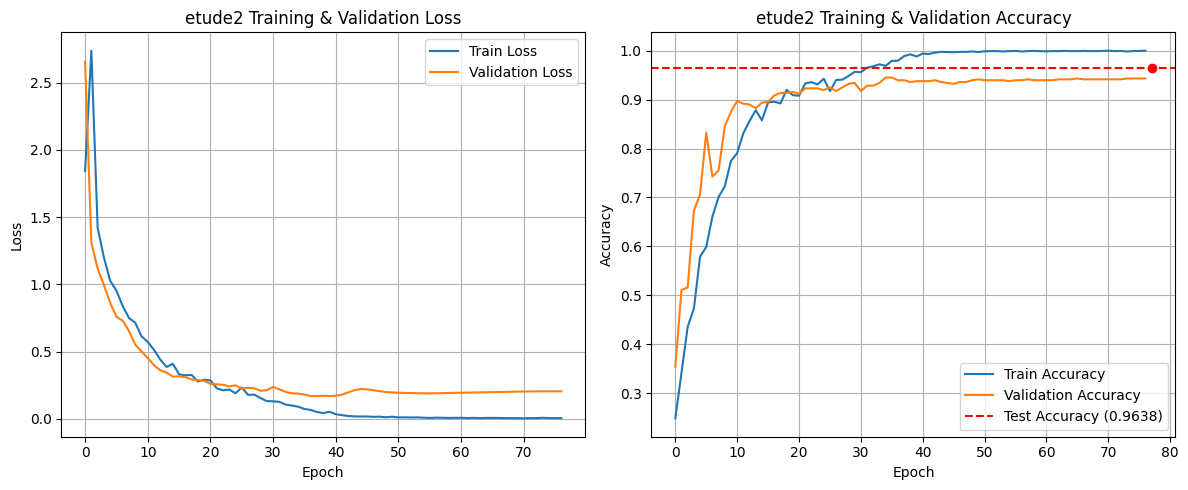

❌ Error plotting training history for 'etude2' from c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\etude2_logs\version_10\metrics.csv: name 'base_output_dir' is not defined

>>> Finished processing study: etude2 <<<

--- RGCN+MLP Training Test Complete ---
Test run finished successfully.
  Log Directory: c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\etude2_logs\version_10
  Best Checkpoint: C:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\output\classification_data\etude2_root_classification_data\checkpoints\best-checkpoint-v10.ckpt
  Test Metrics:
    test_loss: 0.1595
    test_acc: 0.9638
    test_f1: 0.9636
    test_precision: 0.9641
    test_recall: 0.9638


Traceback (most recent call last):
  File "c:\Users\moham\OneDrive\Desktop\spiridon\Spiridon\src\utils.py", line 163, in plot_training_history
    plot_save_dir = os.path.join(base_output_dir, "lightning_logs", study_name, "version_0" if not version_dirs else version_dirs[-1] )
                                 ^^^^^^^^^^^^^^^
NameError: name 'base_output_dir' is not defined


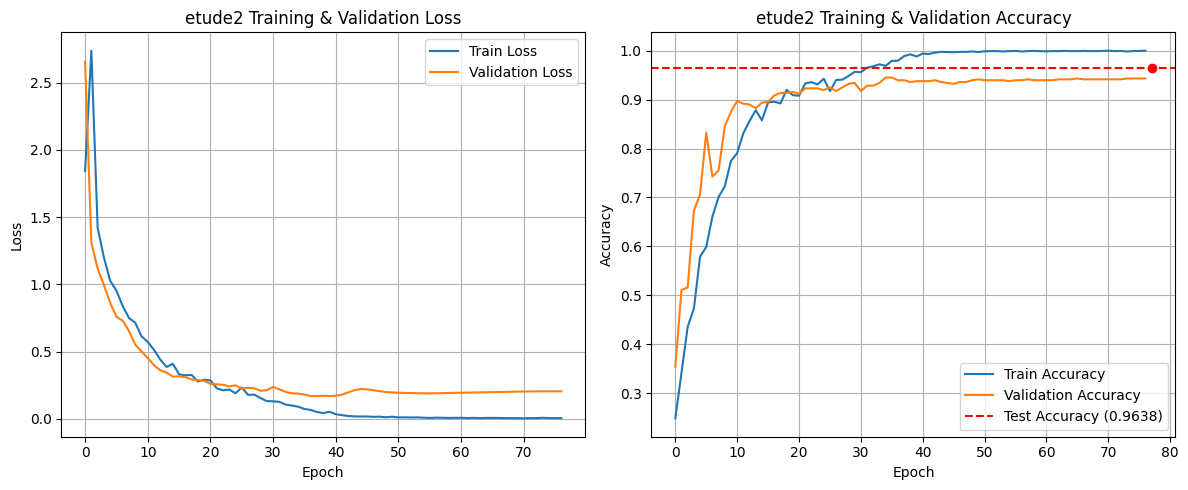

In [3]:
# Import the main training function for the RGCN-based classifier
from src.training.rgcn_mlp_classification_pipeline import train_and_test_classification_model
import torch

print("\n--- Testing RGCN+MLP Training and Evaluation Pipeline ---")
print("NOTE: This test requires the full pre-processed graph data from 'main_prepare_data.py'.")
print("It will fail if the data has not been generated first.")

STUDY_NAME_RGCN = "etude2"
clf_data_dir = os.path.join(config.CLASSIFICATION_DATA_DIR, f"{STUDY_NAME_RGCN}_root_classification_data")
clf_data_file = os.path.join(clf_data_dir, "data.pt")


print(f"\nFound classification data for study '{STUDY_NAME_RGCN}'.")
print("Proceeding with a short training session (2 epochs)...")

# Define lightweight hyperparameters and trainer params for a quick test
test_hyperparams = {
    'rgcn_hidden_dim': 128,
    'learning_rate': 1e-3,
    'patience': 20,
    'dropout': 0.3,
    'l2_reg': 1e-4
}

test_trainer_params = {
    'max_epochs': 100, # Just to test the pipeline runs
    'accelerator': 'cpu', # Force CPU for simple test
    'devices': 1,
    'enable_progress_bar': True
}

# Run the training and evaluation pipeline
rgcn_mlp_results = train_and_test_classification_model(
    study_name=STUDY_NAME_RGCN,
    base_data_dir=config.CLASSIFICATION_DATA_DIR,
    hyperparameters=test_hyperparams,
    trainer_params=test_trainer_params,
    plot_history=True
)

print("\n--- RGCN+MLP Training Test Complete ---")
if rgcn_mlp_results:
    print("Test run finished successfully.")
    print(f"  Log Directory: {rgcn_mlp_results.get('log_dir', 'N/A')}")
    print(f"  Best Checkpoint: {rgcn_mlp_results.get('best_checkpoint_path', 'N/A')}")
    print("  Test Metrics:")
    if rgcn_mlp_results.get('test_metrics'):
        for metric, value in rgcn_mlp_results.get('test_metrics', {}).items():
            print(f"    {metric}: {value:.4f}")
else:
    print("RGCN+MLP training pipeline failed or was skipped.")